# PART 1. Word Counter

In this part, we perform a word count over all the articles in order to retrieve the most recurring words.

## Imports

In [1]:
#Dask
import dask
from dask.distributed import Client, SSHCluster, wait, get_client
import dask.bag as db
import dask.dataframe as dd
import dask.array as da

#Other
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
import pandas as pd
import io
import geonamescache as gps
import time
import seaborn as sns
import funky as f


# from langdetect import LangDetectException
# from langdetect.detector_factory import DetectorFactory
# factory = DetectorFactory()
# factory.load_profile('/home/ubuntu/miniconda3/envs/mapd/lib/python3.13/site-packages/langdetect/profiles')


# def detect(text):
#     detector = factory.create()
#     detector.append(text)
#     return detector.detect()


import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
exceptions = {"ie", "eg", "al", "et", "etc", "also", "however", "fig", "figure", "table"}
garbage = stopwords | exceptions

import logging
logging.getLogger("distributed").setLevel(logging.WARNING)

## Cluster / Client setup

In [ ]:
cluster = SSHCluster(['localhost', 'localhost', '10.67.22.125', '10.67.22.104', '10.67.22.89'],
                     connect_options={'known_hosts': None},
                     scheduler_options={"port": 8786, "dashboard_address": ":8797", },
                     worker_options={'nthreads':1, 'n_workers':4})

In [ ]:
client = Client("localhost:8786")

## Preprocessing

Some problems encountered while retrieving the data were:
- Empty fields: we applied a filter in order to keep only the relevant ones;
- Some of the articles were not in the English language: we tried to use the langdetect package to filter these out. We eventually discarded the idea since we realised the package had specific problems with distributed processing.
- We found duplicate files along the directories 'pmc' and 'pdf'. We made sure to import those only once.
- We found some files written using Latex syntax. We pruned the test in latex for each file (if present).

In [ ]:
a = dd.read_csv('/mnt/data/20/metadata.csv', blocksize='3MB', dtype='string')
print('Partitions: ',a.npartitions)

common_path = '/mnt/data/20/'
pmj = a['pmc_json_files']
pdj = a['pdf_json_files']

clean_pm = pmj.notnull()
clean_pd = pdj.notnull() & pmj.isnull()

pmc = common_path + pmj[clean_pm]
pdf = (common_path + pdj[clean_pd]).replace(r"\;.+", "", regex=True)
# paths=pdf.compute()
paths = dd.concat([pdf, pmc]).compute().to_list()

## Word Count

Our function is built over these main steps:
- We read the data and store it in a `Bag` object.
- We preprocess the data with built-in (and not) filtering functions.
- We perform the word count exploiting the `foldby` and `topkey` methods.

In [ ]:
# Defining functions that help filtering the data

def texter(text):
    no_latex = re.sub(r"(?<=\w)-(?=\w)|\\documentclass.*", "", text, flags=re.DOTALL)
    #try:
    #    if detect(text[:50]) != "en": return None  # Cleanse non english docs
    #except LangDetectException as exc:
    #    if 'No features in text.' in str(exc): return None  # If the text is empty or gibberish (in the first 50 characters) it will be cleansed
    return re.findall(r'\b\w{2,}\b', no_latex.lower())

def filtering(word, garbage=garbage): return word not in garbage and not word.isnumeric() and not word.startswith('http')

In [ ]:
# Creation of the Dask Bag
bag = db.from_sequence(paths, npartitions=64).map(lambda path: json.load(open(path)))

# Preprocessing of the data
preprocessed_data = bag.pluck("body_text").flatten().pluck("text").map(texter).filter(bool).flatten().filter(filtering)

# Word count
count_m = preprocessed_data.foldby(key= lambda x:x, binop=lambda total, _: total+ 1, initial=0, combine=lambda total1, total2: total1+total2, combine_initial=0)\
    .topk(20, lambda x: x[1]).compute()


### Results

In [ ]:
count_m.set_index('Word', inplace=True)
count_m.plot(kind='bar', legend=False, color='lightgreen', edgecolor='green', figsize=(8, 5))

plt.ylabel('Count')
plt.title('Most Frequent Words')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

## Benchmarking

The workflow consisted in executing the following cell with different configurations of the cluster and the bag, i.e. modifying the parameters `n_workers`, `nthreads`, and `num_partitions` in the Bag. We timed each execution and stored in a csv file the result in seconds for each computation.

In [ ]:
# To execute if/when the cluster is already active:
client.shutdown()

In [ ]:
# Modify the cells below to try different configurations.
n_workers=[4,2] #1,2,1,4,...
n_threads=[1,2] #1,2,4,1,...
mult_partitions=[1,3] # 6,10,100: Multipliers of the number of partitions, starting from the minimum of (n_workers) * (n_threads) * (4 nodes)

# Benchmarking cycle
for j in range(len(mult_partitions)): 
    for i in range(len(n_threads)):

        n_partitions = 4 * n_workers[i] * n_threads[i] * mult_partitions[j]
        string = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions) #for storing in the .csv file 
        
        for k in range(3): # timing three times to get a statistics

            # Restart cluster with new parameters
            print('Restarting cluster ...')
            cluster = SSHCluster(['localhost', 'localhost', '10.67.22.125', '10.67.22.104', '10.67.22.89'],
                            connect_options={'known_hosts': None},
                            scheduler_options={"port": 8786, "dashboard_address": ":8797"},
                            worker_options={'nthreads':n_threads[i], 'n_workers':n_workers[i]})
            client=Client(cluster)
            
            # Timing operation. The word count has the same code as above
            print('Starting run ',j+1,'-',i+1,'-',k+1)
            bag = db.from_sequence(paths, npartitions=(n_partitions-1)).map(lambda path: json.load(open(path)))    

            start=time.time()

            preprocessed_data = bag.pluck("body_text").flatten().pluck("text").map(texter).filter(bool).flatten().filter(filtering)
            count_m = preprocessed_data.foldby(key= lambda x:x, binop=lambda total, _: total+ 1, initial=0, combine=lambda total1, total2: total1+total2, combine_initial=0)\
                .topk(20, lambda x: x[1]).compute()
            
            end=time.time()

            # updating the result string
            delta=np.round(end-start,2)
            print('time: ',delta)
            string+=','+str(delta)

            client.shutdown()

        # Write into file
        string += '\n'
        with open('benchmarks_1_d.csv','a') as file:
            file.write(string)
        
        print('End of runs',j+1,'-',i+1)
        
print('End of all runs!')

## Benchmarking results

We plot below the most relevant results of our benchmarking process.

In the first three plots we compared, for 4, 16 and 32 total threads, the computational mean time and std of different cluster configurations and different partition numbers.

In the fourth graph we chose the best configuration from the first three plots, and compared their performances varying the partition numbers.

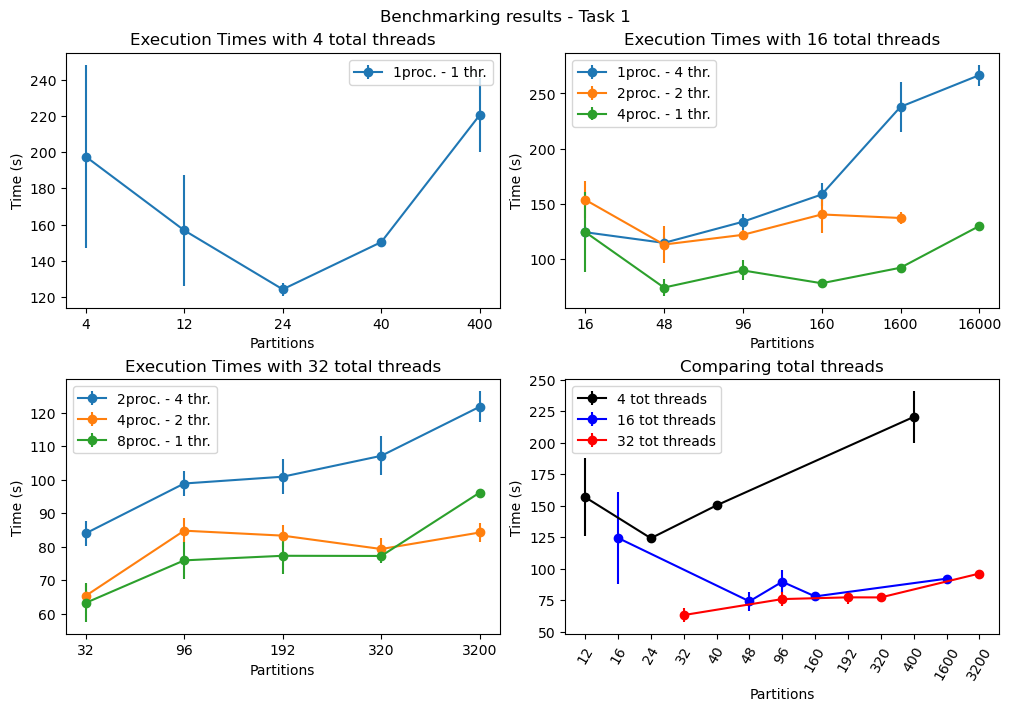

In [ ]:

fig,ax=plt.subplots(2,2,figsize=(10,7),layout='constrained')
fig.suptitle('Benchmarking results - Task 1')

#First, second and third graph

f.plot_performances(f'bm/benchmarks_1_d4.csv',0,0,ax)
f.plot_performances(f'bm/benchmarks_1_d16.csv',0,1,ax)
f.plot_performances(f'bm/benchmarks_1_d32.csv',1,0,ax)

#Third graph

#read and clean data
dfs=[pd.read_csv('bm/benchmarks_1_d4.csv'),pd.read_csv('bm/benchmarks_1_d16.csv'),pd.read_csv('bm/benchmarks_1_d32.csv')]
dfs[1]=dfs[1][dfs[1]['n_workers']==4] #selecting only the best configuration
dfs[2]=dfs[2][dfs[2]['n_workers']==8]
dfs[0]=dfs[0][dfs[0]['n_partitions']>11]
dfs[1]=dfs[1][dfs[1]['n_partitions']<1700]

#setting local variables
partitions=np.concat([dfs[0]['n_partitions'].values,dfs[1]['n_partitions'].values,dfs[2]['n_partitions'].values])
partitions=(np.unique(sorted(partitions)))
colors=['k','blue','red']

#plotting the errorbar
for i in range(3):

    dfs[i]['time']=np.round((dfs[i]['time1']+dfs[i]['time2']+dfs[i]['time3'])/3,2)
    dfs[i]['std']=np.round(np.std([dfs[i]['time1'],dfs[i]['time2'],dfs[i]['time3']],axis=0),2)

    x=[int(np.argwhere(partitions==i)[0][0])+1 for i in dfs[i]['n_partitions'].values]

    num_threads=str(dfs[i]['n_workers'].values[0]*dfs[i]['n_threads'].values[0]*4)
    results=dfs[i].drop(columns=['n_workers','n_threads','time1','time2','time3'])
    y=results.to_numpy()

    ax[1,1].errorbar(x=x,y=y[:,1],yerr=y[:,2],label=f'{num_threads} tot threads',fmt='o-',c=colors[i])
    
ax[1,1].legend()
ax[1,1].set_xticks(np.arange(1,len(partitions)+1,1))
ax[1,1].set_xticklabels(partitions, rotation=60)
ax[1,1].set_title('Comparing total threads')
ax[1,1].set_xlabel('Partitions')
ax[1,1].set_ylabel('Time (s)')
plt.show()

We see that, keeping the same number of total threads, the task is executed faster when multiprocessing instead of multithreading. This could mean that our task is composed mainly of computationally expensive tasks, and it is the bottleneck of the operation rather than the part that requires the communication between partitions. 

We also deduce from the last plot that 32 total threads perform similarly, if not slightly better, than the trivial choice of 16 total threads. As we expected, using only 4 threads is a worse choice since it does not exploit all the computational resources.

Generally speaking, increasing too much the number of partitions leads to worse performances. This is due to the fact that distributing too much the task makes the communication between partitions expensive.